In [19]:
import os
import tempfile

from IPython.display import HTML, display
import matplotlib.pyplot as plt
import numpy as np
import h5py

import tdgl
from tdgl.geometry import box, circle

In [20]:
%config InlineBackend.figure_formats = {"retina", "png"}
%matplotlib inline
os.environ["OPENBLAS_NUM_THREADS"] = "2"
tempdir = tempfile.TemporaryDirectory()

In [21]:
length_units = "um" 

# Material Parameters
xi = 0.5
london_lambda = 2
d = 0.1
layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=1)

# Device geometry
total_width = 5
total_length = 10
link_width = total_width / 3

# Rectangle
film = (
    tdgl.Polygon("film", points=box(total_width, total_length))
    .resample(401)
    .buffer(0)
)

# Source
source = (
    tdgl.Polygon("source", points=box(1.1 * total_width, total_length / 100))
    .translate(dy=total_length / 2)
)

# drain
drain = source.scale(yfact=-1).set_name("drain")

#  Voltage measurement points
probe_points = [(0, total_length / 2.5), (0, -total_length / 2.5)]

# Define device 
device = tdgl.Device(
    "plate",
    layer=layer,
    film=film,
    terminals=[source, drain],
    probe_points=probe_points,
    length_units=length_units,
)


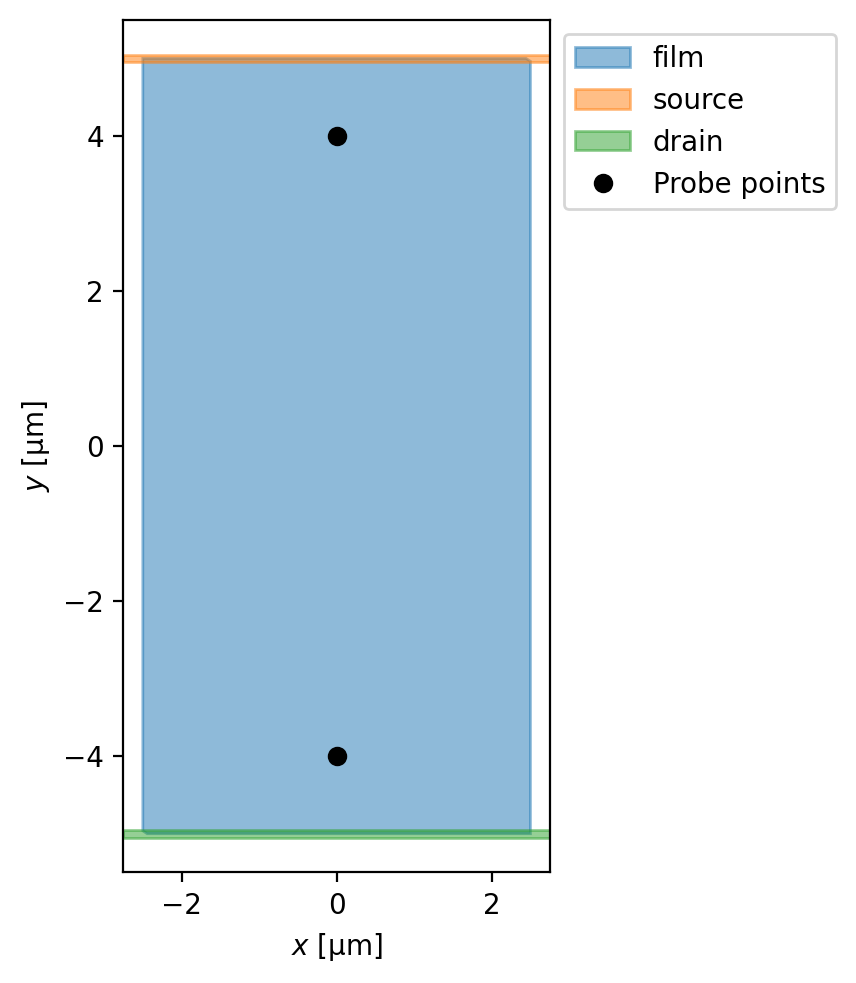

In [22]:
fig, ax = device.draw()

In [23]:
# options for solver
options = tdgl.SolverOptions(
    solve_time=200,
    output_file=os.path.join(tempdir.name, "campo_corriente.h5"),
    field_units="mT",
    current_units="uA",
)

In [24]:
# make mesh
device.make_mesh(max_edge_length=xi/2, smooth=100)

Constructing Voronoi polygons: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3241/3241 [00:00<00:00, 31958.42it/s]


In [25]:
# Graph current vs voltage
def get_mean_voltage(device, options, current):
  terminal_currents = {
      'source': current,
      'drain': -current
  }

  solution = tdgl.solve(device=device, options=options, terminal_currents=terminal_currents)
  voltage = solution.dynamics.mean_voltage()
  return voltage

currents = np.arange(0.0, 50, 0.1)
voltages = []
intensities = []

for current in currents:
  voltage = get_mean_voltage(device=device, options=options, current=current)
  voltages.append(voltage)
  intensities.append(current)


Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 200/200 [00:02<00:00, 70.27tau/s ]
Output file already exists. Renaming to /var/folders/wj/6c0c3ct90nx1b15wlmd9y0xr0000gp/T/tmpm5ltu0mp/campo_corriente-1.h5.
Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 200/200 [00:05<00:00, 34.61tau/s ]
Output file already exists. Renaming to /var/folders/wj/6c0c3ct90nx1b15wlmd9y0xr0000gp/T/tmpm5ltu0mp/campo_corriente-2.h5.
Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 200/200 [00:05<00:00, 35.10tau/s ]
Output file already exists. Renaming to /var/folders/wj/6c0c3ct90nx1b15wlmd9y0xr0000gp/T/tmpm5ltu0mp/campo_corriente-3.h5.
Simulating: 100%|████████████████████████████████████████████

ValueError: x and y must have same first dimension, but have shapes (500,) and (1,)

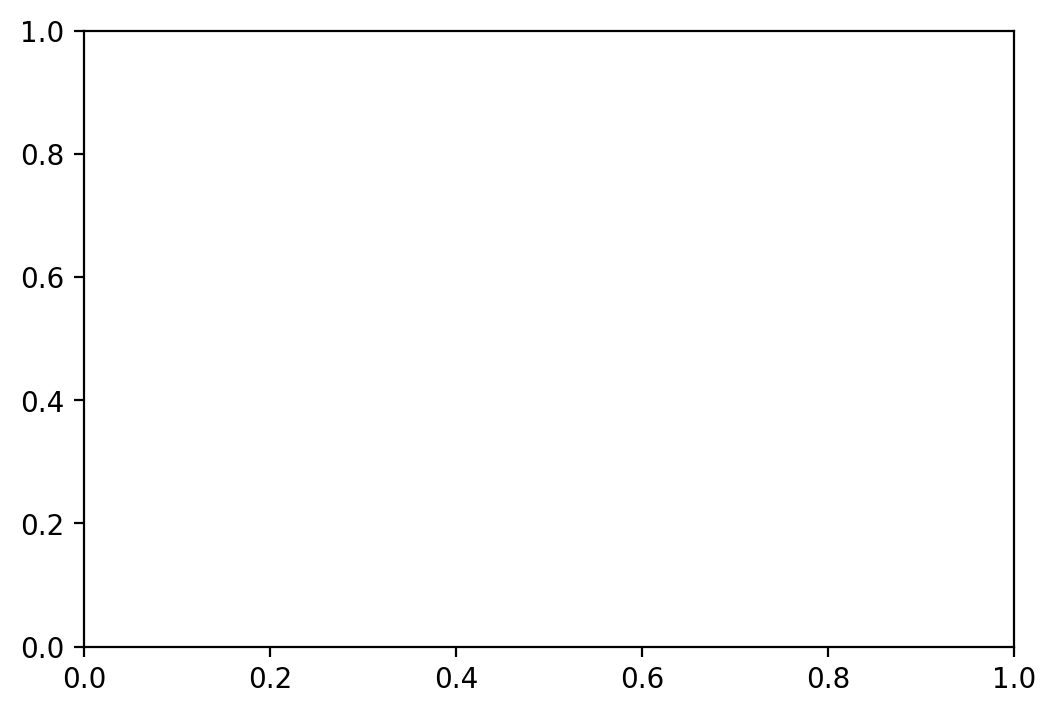

In [27]:

plt.figure(figsize=(6, 4))
plt.plot(intensities, voltage, marker='o', linestyle='-', color='blue')
plt.xlabel('Corriente (µA)')
plt.ylabel('Voltaje promedio (V)')
plt.grid(True)
plt.tight_layout()
plt.show()